In [1]:
#### Wavelet denoising
import sys
sys.path.append(r'D:\Anaconda\Lib\site-packages')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import numba
import pywt
import struct
from numba import jit
import time as ti
import array
from scipy import signal
from scipy.interpolate import interp1d
from scipy.fftpack import fft,ifft
from scipy.fft import fftshift

In [ ]:
def read_header(run_filename):
    stream = open(run_filename,"rb")
    print("open file ",run_filename)
    pstt = 0.
    FiredD = 0
    V1724_1_DAC = [0]*8
    V1724_1_Tg = [0]*8
    V1724_1_twd = 0
    V1724_1_pretg = 0
    V1724_1_opch = 0
    V1724_2_DAC = [0]*8
    V1724_2_Tg = [0]*8
    V1724_2_twd = 0
    V1724_2_pretg = 0
    V1724_2_opch = 0
    V1721_DAC = [0]*8 #V1724-1 Channel DAC     
    V1721_Tg = [0]*8  #V1724-1 Trigger Settings
    V1721_twd = 0      #V1724-1 Time Window     
    V1721_pretg = 0    #V1724-1 Pre Trigger     
    V1721_opch = 0     #V1724-1 Opened Channel
    V1729_th_DAC = 0
    V1729_posttg = 0
    V1729_tgtype = 0
    V1729_opch = 0
    rstt = 0.
    redt = 0.

    print("***************************Run Header**************************************\n");
    pstt = struct.unpack("d", stream.read(8))[0]
    print("* Program Start Time:",pstt," s.\n");
    FiredD = struct.unpack("I", stream.read(4))[0]
    print("* Fired Devices: ",FiredD," ( V1724-1 | V1724-2 | V1729)\n\n")

    print("* V1724-1 Channel DAC:      ")
    for i in range(8):
        V1724_1_DAC[i] = struct.unpack("I", stream.read(4))[0]
        print(V1724_1_DAC[i],"\t")
    print("\n")

    V1724_1_twd = struct.unpack("I", stream.read(4))[0]
    print("* V1724-1 Time Window:  ",V1724_1_twd,"\n")
    V1724_1_pretg = struct.unpack("I", stream.read(4))[0]
    print("* V1724-1 Pre Trigger: ",V1724_1_pretg,"\n")
    V1724_1_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1724-1 Opened Channel: ",V1724_1_opch,"\n\n")

    #V1724-2 Settings
    print("* V1724-2 Channel DAC:      ");
    for i in range(8):
        V1724_2_DAC[i] = struct.unpack("I", stream.read(4))[0]
        print(V1724_2_DAC[i],"\t")
    print("\n")

    V1724_2_twd = struct.unpack("I", stream.read(4))[0]
    print("* V1724-2 Time Window:  ",V1724_2_twd,"\n")
    V1724_2_pretg = struct.unpack("I", stream.read(4))[0]
    print("* V1724-2 Pre Trigger: ",V1724_2_pretg,"\n")
    V1724_2_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1724-2 Opened Channel: ",V1724_2_opch,"\n\n")

    V1729_th_DAC = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Threshold DAC:  ",V1729_th_DAC,"\n")
    V1729_posttg = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Post Trigger: ",V1729_posttg,"\n")
    V1729_tgtype = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Trigger Type: ",V1729_tgtype,"\n")
    V1729_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1729 Opened Channel: ",V1729_opch,"\n\n")

    #V1721 Settings
    print("* V1721 Channel DAC:        ")
    for i in range(8):
        V1724_2_DAC[i] = struct.unpack("I", stream.read(4))[0]
        print(V1724_2_DAC[i],"\t")
    print("\n")
    V1721_twd = struct.unpack("I", stream.read(4))[0]
    print("* V1721 Time Window: ",V1721_twd,"\n")
    V1721_pretg = struct.unpack("I", stream.read(4))[0]
    print("* V1721 Pre Trigger: ",V1721_pretg,"\n")
    V1721_opch = struct.unpack("I", stream.read(4))[0]
    print("* V1721 Opened Channel: ",V1724_1_opch,"\n")

    rstt = struct.unpack("d", stream.read(8))[0]
    print("* Run Start Time: ",rstt," s.\n")
    print("***************************************************************************\n");

    #event header
    Hit_pat = 0
    V1729_tg_rec = 0
    Evt_deadtime = 0
    Evt_starttime = 0
    Evt_endtime = 0
    V1724_1_tgno = 0
    V1724_2_tgno = 0
    V1721_tgno = 0
    V1724_1_tag = 0
    print("current point position: ",stream.tell(),"\n")
#     Hit_pat = struct.unpack("I", stream.read(4))[0]
#     V1729_tg_rec = struct.unpack("I", stream.read(4))[0]
#     Evt_deadtime = struct.unpack("I", stream.read(4))[0]
#     Evt_starttime = struct.unpack("I", stream.read(4))[0]
#     Evt_endtime = struct.unpack("I", stream.read(4))[0]
#     V1724_1_tgno = struct.unpack("I", stream.read(4))[0]
#     V1724_2_tgno = struct.unpack("I", stream.read(4))[0]
#     V1721_tgno = struct.unpack("I", stream.read(4))[0]
#     V1724_1_tag = struct.unpack("I", stream.read(4))[0]
    
    return V1724_1_opch,V1724_1_twd

# read an event pulse, output the preamp pulse
def read_event(filename,event_index,V1724_1_opch,V1724_1_twd,channel=1,EVENT_NUMBER = 10000):#channel=1 means preamplifier
    MAX_WINDOWS = V1724_1_twd
    if(channel>=V1724_1_opch):
        print("channel number error")
        return

    run = int(event_index/EVENT_NUMBER)
    evt = event_index%EVENT_NUMBER+1

    stream = open(filename,"rb")
    
    stream.seek(168,0)                                           #skip the header, 168 is file header size
    stream.seek((4*9+2*V1724_1_opch*V1724_1_twd)*(evt-1)+4*9,1) #skip to the target event,and skip the event header info(size is 4*9) 

    V1724_1_pulse = np.zeros((V1724_1_twd,),dtype=int)
    V1724_1_pulse[:]=np.fromfile(stream,dtype="H",count=MAX_WINDOWS,offset=MAX_WINDOWS*2*channel).astype(int)
    return V1724_1_pulse


def MoveA(Npoint,Data):
    Out=np.zeros(len(Data),)
    front_ave=0
    for i in range(Npoint):
        front_ave+=Data[i]/float(Npoint)
    Out[0:Npoint]=front_ave
    sum=front_ave*Npoint
    for i in range(Npoint,len(Data)):
        sum=sum+Data[i]-Data[i-Npoint]
        Out[i]=sum/float(Npoint)
    return Out
        

def NMoveA(Npoint,Ntimes,Data):
    for i in range(Ntimes):
        Data=MoveA(Npoint,Data)
    return Data




In [1]:
print("a")

a


In [ ]:
class waveform(object):
    def __init__(self,filename,iterator,par_num={"A":12,"E":1},window=12000,eventN=10000,mfilter=None):
        self.filename=filename
        self.iterator=iterator
        self.window=window
        self.raww=np.zeros((window,))
        self.processedw=np.zeros((window,))
        self.opch=3 #open channel number
        self.eventN=eventN
        self.maxindex=0
        self.max=0
        self.rise_point=0
        self.A_num=par_num["A"]
        self.E_num=par_num["E"]
        
        #creating wavelet and define parameters

        self.A=np.zeros((len(iterator)*eventN,par_num["A"]))
        self.E=np.zeros((len(iterator)*eventN,par_num["E"]))
        
        ### if use matched filter, read the filter array:
        if(mfilter!=None):
            self.mfilter=np.load(mfilter)
    
    def read_event(self,filename,event_index,channel=1):#channel=1 means preamplifier

        if(channel>=self.opch):
            print("channel number error")
            return
        run = int(event_index/self.eventN)
        evt = event_index%self.eventN+1

        stream = open(filename,"rb")

        stream.seek(168,0)                                           #skip the header, 168 is file header size
        stream.seek((4*9+2*self.opch*self.window)*(evt-1)+4*9,1) #skip to the target event,and skip the event header info(size is 4*9) 

        self.raww=np.fromfile(stream,dtype="H",count= self.window,offset= self.window*2*channel).astype(int)       
        
    def iterate(self,iterator_=None,path="G:/CDEX/wave_par/%d_%d",Aname="A",Ename="E"):
        count=-1
        ##########################if want to use multi thread, should give iterator
        it=[]
        if(iterator_==None):
            it=[n for n in self.iterator]
        if(iterator_!=None):
            it=[n for n in iterator]

        ##########################read and processe the wave
        #print(it)
        for n in it:
            filename=self.filename%n
            for j in range(self.eventN):   
                count+=1                 ###############this line required the iterator is [...,1,2,...N]
                if(count%1000==0):
                    print(j+n*self.eventN)
                    
                self.read_event(filename,j,channel=1)
                self.rise_point=0
            
######################### get E

#                 self.cut_around_risep(0.5,4096)
#                 self.TrapShapping(400,500,900,-1e-4)
#                 self.MWA(90)
#                 self.E[count,0]=self.max_amp()
#####get E done        
                
######################### get A 
#GERDA method
                #####
                k=0
                MAWindow=21
                inter_num=5
                inter_win=2048
                threshold=np.linspace(1,5,5,endpoint=True)
                
                #plt.plot(self.raww)
                self.cut_around_risep(0.5,inter_win,MWApn=21)

#                 plt.plot(self.processedw)
#                 self.rise_p()
#                 print(self.rise_point-int(MAWindow/2))
#                 self.cut_around(0.5,win=inter_win,point=self.rise_point-int(MAWindow/2))  ##phase lock

                self.interpolate(inter_num,'cubic')
                pulse_interpolated=np.zeros((inter_win*inter_num,))
                pulse_interpolated[:]=self.processedw[:]                            ##save temp pulse,used after

                self.Partial(inter_num*5)
                pulse_partialed=np.zeros((inter_win*inter_num,))
                pulse_partialed[:]=self.processedw[:]                               ##save temp pulse,used after

                
                for thre in range(len(threshold)):
                    self.processedw[:]=pulse_partialed[:]
                    self.wavelet_denoise('bior6.8',thre)

                    self.A[count,k]=self.max_amp()

                    k+=1
                ###########################################
                
#CDEX method 
                ####
                for thre in range(len(threshold)):
                    self.processedw[:]=pulse_interpolated[:]
                    self.wavelet_denoise('bior6.8',thre)
                    self.Partial(inter_num*5)
                    self.A[count,k]=self.max_amp()
                    k+=1
                ###########################################

#MWA method   
                ###
                self.cut_around_risep(0.5,4096)
                self.NMWA(5,3)                ##5point 3times moving window average
                self.interpolate(inter_num,'cubic')
                self.Partial(inter_num*5)
                self.A[count,k]=self.max_amp()
                k+=1
                ###########################################
#get A done
                self.save(path%it[0]%it[-1],Aname,Ename)
                
                

#                 ###
#                 threshold=[1,2,3,4,5]
#                 k=0
#                 for i in range(5):
#                     self.cut_around_risep(0.5,4096)
#                     self.wavelet_denoise('db5',3)
#                     self.Partial(5)
#                     self.A[count,k]=self.max_amp()
#                     k+=1
#                 ###
#                 win=2048
#                 self.cut_around_risep(0.5,win)
#                 self.wavelet_denoise('db5',3)
#                 self.interpolate(5,'cubic')
#                 self.Partial(25)
#                 self.A[count,k]=self.max_amp()
#                 k+=1
                #######

                
    def save(self,path="G:/CDEX/wave_par/",Aname=None,Ename=None):
        if(Aname!=None):
            np.save(path+Aname,self.A)
        if(Ename!=None):
            np.save(path+Ename,self.E)          
            

    
    def AssignRange(self,start=0,end=12000):
        self.processedw=np.zeros((end-start,))
        self.processedw[:]=self.raww[start:end]

    def Partial(self,Npoint):
        py=np.array([1])
        px=np.zeros((Npoint+1,))
        px[0]=1
        px[Npoint]=-1
        self.processedw=signal.lfilter(px,py,self.processedw)
        
    
    def MWA(self,Npoint):
        py=np.array([1])
        px=np.zeros((Npoint,))+1./Npoint
        self.processedw=signal.lfilter(px,py,self.processedw)


    def NMWA(self,Npoint,Ntimes):
        for i in range(Ntimes):
            self.MWA(Npoint)
    

        
    def invert(self):
        self.processedw=self.processedw[0:1000].mean()-self.processedw
    
    def max_amp(self):
        return self.processedw.max()-self.processedw[0:1000].mean()
    
    def rise_p(self,threshold=0.5):
        self.maxindex=self.processedw.argmax()
        for i in range(self.maxindex,0,-1):
            if(self.processedw[i]<=threshold*self.processedw[self.maxindex]):
                self.rise_point=i
                return i

    def cut_around_risep(self,threshold=0.5,win=4096,MWApn=None):
        self.AssignRange()
        self.invert()
        if(MWApn!=None):
            self.MWA(MWApn)
            self.rise_p(threshold)
            self.rise_point=self.rise_point-int(MWApn/2)
        else:
            self.rise_p(threshold)
        self.rise_point=min(self.rise_point,self.window-win/2)
        self.rise_point=max(self.rise_point,win/2)
        L=int(self.rise_point-win/2)
        H=int(self.rise_point+win/2)
        self.processedw=self.processedw[L:H]
        
    def cut_around(self,threshold=0.5,win=4096,point=3000):
        self.AssignRange()
        self.invert()
        point=min(point,self.window-win/2)
        point=max(point,win/2)
        L=int(point-win/2)
        H=int(point+win/2)
        self.processedw=self.processedw[L:H]
        
        
    def TrapShapping(self,na,nb,nc,theta):
        a=np.array([1,-2,1])
        b=np.zeros((nc+3,))
        e=math.exp(theta)
        b[1]=1./na
        b[na+1]=-1./na
        b[nb+1]=-1./na
        b[nc+1]=1./na
        b[2]=-e/na
        b[na+2]=e/na
        b[nb+2]=e/na
        b[nc+2]=-e/na
        self.processedw=signal.lfilter(b,a,self.processedw)

    def wavelet_denoise(self,wave,threshold):
        wavelet=pywt.Wavelet(wave)
        maxlev=pywt.dwt_max_level(len(self.processedw),wavelet)
        coeffs=pywt.wavedec(self.processedw,wavelet,level=maxlev) #将信号进行小波分解
        coeffs=sigmoid_th(coeffs,threshold,3)
        self.processedw=pywt.waverec(coeffs,wave)
        
    def interpolate(self,in_num,in_kind='cubic'):
        length=len(self.processedw)
        x_t=np.linspace(0,length-1,length,endpoint=True)
        f=interp1d(x_t,self.processedw,kind=in_kind)
        
        new_x=np.linspace(0,length-1,length*in_num,endpoint=True)
        self.processedw=f(new_x)

    def read_header(self):
        run_filename=self.filename%self.iterator[0]
        stream = open(run_filename,"rb")
        print("open file ",run_filename)
        pstt = 0.
        FiredD = 0
        V1724_1_DAC = [0]*8
        V1724_1_Tg = [0]*8
        V1724_1_twd = 0
        V1724_1_pretg = 0
        V1724_1_opch = 0
        V1724_2_DAC = [0]*8
        V1724_2_Tg = [0]*8
        V1724_2_twd = 0
        V1724_2_pretg = 0
        V1724_2_opch = 0
        V1721_DAC = [0]*8 #V1724-1 Channel DAC     
        V1721_Tg = [0]*8  #V1724-1 Trigger Settings
        V1721_twd = 0      #V1724-1 Time Window     
        V1721_pretg = 0    #V1724-1 Pre Trigger     
        V1721_opch = 0     #V1724-1 Opened Channel
        V1729_th_DAC = 0
        V1729_posttg = 0
        V1729_tgtype = 0
        V1729_opch = 0
        rstt = 0.
        redt = 0.

        print("***************************Run Header**************************************\n");
        pstt = struct.unpack("d", stream.read(8))[0]
        print("* Program Start Time:",pstt," s.\n");
        FiredD = struct.unpack("I", stream.read(4))[0]
        print("* Fired Devices: ",FiredD," ( V1724-1 | V1724-2 | V1729)\n\n")

        print("* V1724-1 Channel DAC:      ")
        for i in range(8):
            V1724_1_DAC[i] = struct.unpack("I", stream.read(4))[0]
            print(V1724_1_DAC[i],"\t")
        print("\n")

        V1724_1_twd = struct.unpack("I", stream.read(4))[0]
        print("* V1724-1 Time Window:  ",V1724_1_twd,"\n")
        V1724_1_pretg = struct.unpack("I", stream.read(4))[0]
        print("* V1724-1 Pre Trigger: ",V1724_1_pretg,"\n")
        V1724_1_opch = struct.unpack("I", stream.read(4))[0]
        print("* V1724-1 Opened Channel: ",V1724_1_opch,"\n\n")

        #V1724-2 Settings
        print("* V1724-2 Channel DAC:      ");
        for i in range(8):
            V1724_2_DAC[i] = struct.unpack("I", stream.read(4))[0]
            print(V1724_2_DAC[i],"\t")
        print("\n")

        V1724_2_twd = struct.unpack("I", stream.read(4))[0]
        print("* V1724-2 Time Window:  ",V1724_2_twd,"\n")
        V1724_2_pretg = struct.unpack("I", stream.read(4))[0]
        print("* V1724-2 Pre Trigger: ",V1724_2_pretg,"\n")
        V1724_2_opch = struct.unpack("I", stream.read(4))[0]
        print("* V1724-2 Opened Channel: ",V1724_2_opch,"\n\n")

        V1729_th_DAC = struct.unpack("I", stream.read(4))[0]
        print("* V1729 Threshold DAC:  ",V1729_th_DAC,"\n")
        V1729_posttg = struct.unpack("I", stream.read(4))[0]
        print("* V1729 Post Trigger: ",V1729_posttg,"\n")
        V1729_tgtype = struct.unpack("I", stream.read(4))[0]
        print("* V1729 Trigger Type: ",V1729_tgtype,"\n")
        V1729_opch = struct.unpack("I", stream.read(4))[0]
        print("* V1729 Opened Channel: ",V1729_opch,"\n\n")

        #V1721 Settings
        print("* V1721 Channel DAC:        ")
        for i in range(8):
            V1724_2_DAC[i] = struct.unpack("I", stream.read(4))[0]
            print(V1724_2_DAC[i],"\t")
        print("\n")
        V1721_twd = struct.unpack("I", stream.read(4))[0]
        print("* V1721 Time Window: ",V1721_twd,"\n")
        V1721_pretg = struct.unpack("I", stream.read(4))[0]
        print("* V1721 Pre Trigger: ",V1721_pretg,"\n")
        V1721_opch = struct.unpack("I", stream.read(4))[0]
        print("* V1721 Opened Channel: ",V1724_1_opch,"\n")

        rstt = struct.unpack("d", stream.read(8))[0]
        print("* Run Start Time: ",rstt," s.\n")
        print("***************************************************************************\n");

        #event header
        Hit_pat = 0
        V1729_tg_rec = 0
        Evt_deadtime = 0
        Evt_starttime = 0
        Evt_endtime = 0
        V1724_1_tgno = 0
        V1724_2_tgno = 0
        V1721_tgno = 0
        V1724_1_tag = 0
        print("current point position: ",stream.tell(),"\n")
    #     Hit_pat = struct.unpack("I", stream.read(4))[0]
    #     V1729_tg_rec = struct.unpack("I", stream.read(4))[0]
    #     Evt_deadtime = struct.unpack("I", stream.read(4))[0]
    #     Evt_starttime = struct.unpack("I", stream.read(4))[0]
    #     Evt_endtime = struct.unpack("I", stream.read(4))[0]
    #     V1724_1_tgno = struct.unpack("I", stream.read(4))[0]
    #     V1724_2_tgno = struct.unpack("I", stream.read(4))[0]
    #     V1721_tgno = struct.unpack("I", stream.read(4))[0]
    #     V1724_1_tag = struct.unpack("I", stream.read(4))[0]
        self.window=V1724_1_twd
        self.opch=V1724_1_opch
        return V1724_1_opch,V1724_1_twd
    
        
def Gerda_sigmoid_th(coeffs,Th=1,s=0.2):
    for i in range(len(coeffs)):
        coeffs[i]=coeffs[i]/(1+np.exp(1/(s*(1-abs(coeffs[i])/Th))))
    return coeffs     

def sigmoid_th(coeffs,Th=2,s=3):
    for i in range(len(coeffs)):
        coeffs[i]=coeffs[i]*np.maximum(0,-1+2/(1+np.exp(-((abs(coeffs[i])-Th)*s))))
    return coeffs

#@jit('f8[:](f8[:],f8,f8,f8,f8)')      
def TrapShapping_(Vin,na,nb,nc,theta):
    d=math.exp(theta)
    N=Vin.shape[0]
    Vout=np.zeros((N,1))
    vi1=0
    vo1=0
    for k in np.arange(N):
        if(k-nc-1>=0):
            vi1=Vin[k-1]-Vin[k-na-1]-Vin[k-nb-1]+Vin[k-nc-1]
        elif(k-1<0):
            vi1=0
            vi2=0
        elif(k-na-1<0):
            vi1=Vin[k-1]
        elif(k-nb-1<0):
            vi1=Vin[k-1]-Vin[k-na-1]
        else:
            vi1=Vin[k-1]-Vin[k-na-1]-Vin[k-nb-1]
        
        if(k-1<0):
            vo1=0
            vo2=0
        else:
            vo1=Vout[k-1]

        Vout[k]=2*vo1-vo2+1/na*(vi1-d*vi2)
        vi2=vi1
        vo2=vo1
    return Vout

def

def ZACfilter(Taos,L,FT,deltaT,Tao):
    A=3*(2*Taos*math.cosh(L/Taos)+FT*math.sinh(L/Taos))/L**3
    print(A)
    Filter_length=2*L+FT
    Npoint=int(Filter_length/deltaT)
    conv=-math.exp(-deltaT/Tao)
    ZAC=np.arange(Npoint,dtype=float)
    FF =np.arange(Npoint-1,dtype=float)
    print(Npoint)
    ####################################################################
    for i in np.arange(Npoint):
        t=deltaT*i
        if(0<t and t<L ):
            ZAC[i]=math.sinh(t/Taos)+A*((t-L/2)**2-(L/2)**2)
        elif(L<=t and t<L+FT):
            ZAC[i]=math.sinh(L/Taos)
        elif(L+FT<=t and t<2*L+FT):
            ZAC[i]=math.sinh((2*L+FT-t)/Taos)+A*((3/2*L+FT-t)**2-(L/2)**2)
    #####################################################################
    #plt.plot(ZAC)
    for i in np.arange(Npoint-1):
        FF[i]=ZAC[i]*conv+ZAC[i+1]
    #####################################################################
    return FF,ZAC
   
def ZACshapping(Vin,FF):
    N_zac=FF.shape[0]
    N_vin=Vin.shape[0]
    N_vout=N_vin-N_zac+2
    Vout=np.arange(N_vout)
    print(N_vout)
    for i in np.arange(N_vout):
        Vout[i]=0
        for k in np.arange(i,i+N_zac-2):
            Vout[i]+=Vin[k]*FF[i+N_zac-1-k]
    return Vout


In [ ]:

filename="G:/CDEX/DATA/20200331_t3_Th_BEGe_2026_6us_0.5_5_2111_0.5_10_Difout10_FADC_RAW_Data_%d.bin"
# wave=waveform(filename,range(1))
# t1=ti.time()
# #wave.read_header()
# wave.iterate()
# # wave.read_event(filename%0,0)
# # wave.AssignRange()
# # wave.invert()
# # wave.NMWA(21,1)
# # plt.plot(wave.processedw)
# # rp=wave.rise_p()
# # wave.cut_around(0.5,2048,rp-10)

# # print(rp)

# # plt.plot(wave.processedw)
# # #wave.iterate()
# print(ti.time()-t1)
# wave.save(Aname="A_bio_6_8")

In [13]:
#label text
#############
x_label="Energy [keV]"
y_label="Count/keV(Uniformed)"
E=np.load(r"E:\CDEX\0vbb\Code\AE_par\E_Trap.npy")

#############
fig, ax = plt.subplots(1,1,figsize=(10, 6),dpi=1200)

n,bins,patchs=ax.hist(E,bins=2000,range=[0,1500],density=True,histtype='step',log=True,\
                      linewidth=0.3,color='black')
ax.set(xlabel=x_label,ylabel=y_label)
plt.subplots_adjust(left=0.10, bottom=0.10, right=0.97, top=0.97,
                wspace=0.15, hspace=0.25)
#plt.show()
#fig.savefig("G:/CDEX/E.png")
print(E.shape)

(1880000, 1)


In [17]:
#label text
#############
x_label="Energy [keV]"
y_label="A (max current amp)"
E=np.load(r"E:\CDEX\0vbb\Code\AE_par\E_Trap.npy")
A=np.load(r"E:\CDEX\0vbb\Code\AE_par\A_bio_6_8.npy")
print(np.argwhere(E==0)[0:100])
AoE=(A/E)
x=np.zeros((1880000,))
y=np.zeros((1880000,))


[[1181915       0]
 [1691313       0]
 [1781072       0]]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
print("abc%d_%d"%(2,3))

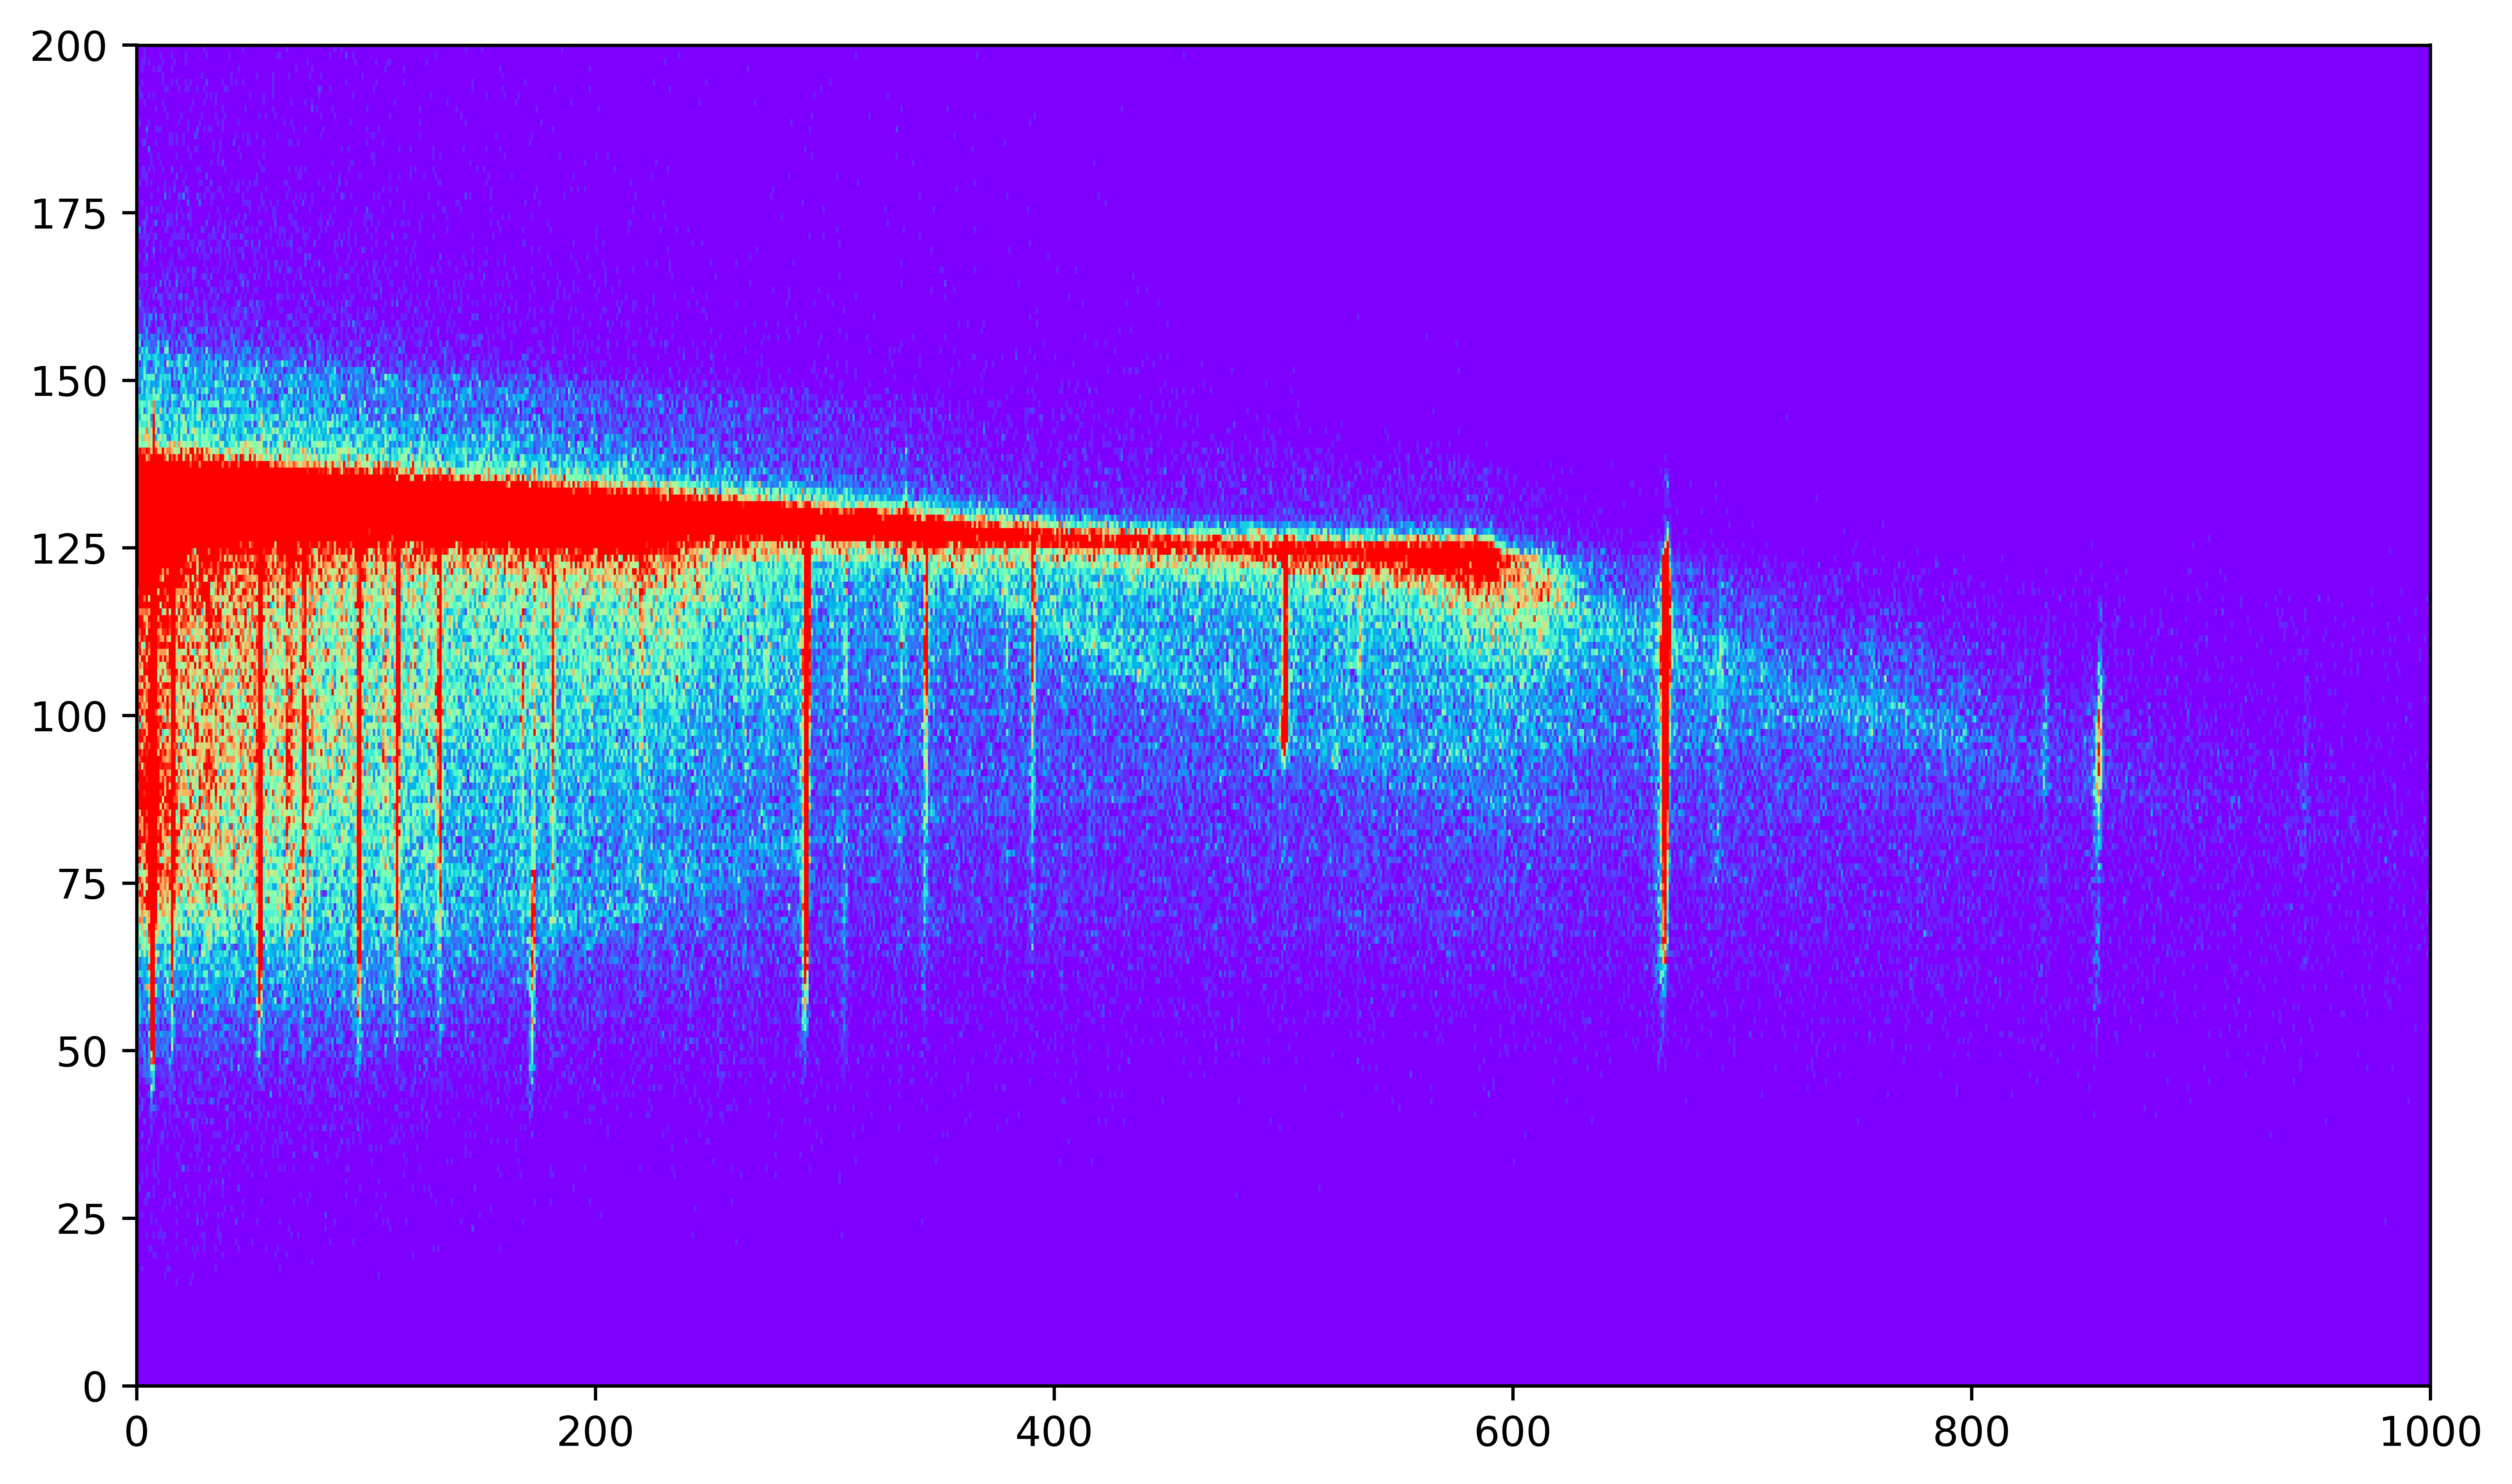

In [39]:

x=E[:,0]
y=AoE[:,10]


#############
fig, ax = plt.subplots(1,1,figsize=(10, 6),dpi=900)

heatmap, xedges, yedges = np.histogram2d(x,y ,bins=[1000,200],range=[[200,1300],[0,0.6]])
#extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
extent=[0,1500,0,10]


#plt.imshow(heatmap.T, extent=extent, origin='lower')
#ax.set_xlim(0,1500)
#ax.set_ylim(0,0.8)
#ax.scatter(x,y,s=0.05)
ax.pcolormesh(heatmap.T,cmap='rainbow',vmax=20)
plt.show()

# ax.set(xlabel=x_label,ylabel=y_label)
# plt.subplots_adjust(left=0.10, bottom=0.10, right=0.97, top=0.97,
#                 wspace=0.15, hspace=0.25)
#plt.show()
#fig.savefig("G:/CDEX/AE_wave3.png")

In [ ]:
print(heatmap.shape)
AoE=(A/E)[:,0]
heatmap[0:4,0:4]

In [ ]:

print(np.ceil(2))

In [1]:
import sys
sys.path.append(r'E:\CDEX\0vbb\Paper\AOVERE')# modify
import time
import multiprocessing
import numpy as np
import waveform

time_start=time.time()

filename="G:/CDEX/DATA/20200331_t3_Th_BEGe_2026_6us_0.5_5_2111_0.5_10_Difout10_FADC_RAW_Data_%d.bin"#modify
savename="G:/CDEX/wave_par/"
it_num=32
file_num=188

def pack_result(result_name):
    A=result[0][0]
    for i in range(1,len(result)):
        A=np.append(A,result[i][0],axis=0)
    np.save(result_name+"A_bio_6_8",A)
    
    E=result[0][1]
    for i in range(1,len(result)):
        E=np.append(E,result[i][1],axis=0)
    np.save(result_name+"E_trap",E)

if __name__=="__main__":
    
#     pool = multiprocessing.Pool()
#     it=waveform.get_it(filename,range(4),3)
#     result = pool.starmap_async(waveform.get_par, it).get()
#     pool.close()
#     pool.join()
#     pack_result(savename)
    print("time cost: ")
    print(time.time()-time_start," s")   



time cost: 
0.0  s


In [10]:
print(waveform.get_it(filename,range(6),4))

(('G:/CDEX/DATA/20200331_t3_Th_BEGe_2026_6us_0.5_5_2111_0.5_10_Difout10_FADC_RAW_Data_%d.bin', range(0, 2)), ('G:/CDEX/DATA/20200331_t3_Th_BEGe_2026_6us_0.5_5_2111_0.5_10_Difout10_FADC_RAW_Data_%d.bin', range(2, 4)), ('G:/CDEX/DATA/20200331_t3_Th_BEGe_2026_6us_0.5_5_2111_0.5_10_Difout10_FADC_RAW_Data_%d.bin', range(4, 6)))


In [ ]:
import numpy as np
a=result[0][0]
for i in range(1,len(result)):
    a=np.append(a,result[i][0],axis=0)
print(a.shape)
np.save("a",a)

In [ ]:
def get_it(filename,iterator,it_num):
    length=int(len(iterator)/it_num)
    it=[]
    for i in range(it_num):
        a=(filename,range(i*length,min((i+1)*length,len(iterator))))
        it.append(a)
    if((i+1)*length<len(iterator)):
        a=(filename,range((i+1)*length,len(iterator)))
        it.append(a)
    return tuple(it)

print(get_it("file",range(188),18))

In [ ]:
def get_it(filename,iterator,it_num):
    length=int(len(iterator)/it_num+1)
    it=[]
    for i in range(it_num):
        a=(filename,range(i*length,min((i+1)*length,len(iterator))))
        it.append(a)
    return tuple(it)
print(get_it("file",range(188),10))

In [ ]:
import time
a=[1]
b=[1/5,1/5,1/5,1/5,1/5]
a=np.zeros((12000,))
s=time.time()
#MoveA(5,V1724_1_pulse)
#signal.lfilter(b,a,V1724_1_pulse)
#a=V1724_1_pulse[0:1000].mean()-V1724_1_pulse[0:12000]

print(time.time()-s)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(14,8),dpi=500)
time=np.linspace(0,120,12000)
ax.plot(time,V1724_1_pulse[:])
plt.show()

In [ ]:
#read the header
filename="G:/CDEX/DATA/20200331_t3_Th_BEGe_2026_6us_0.5_5_2111_0.5_10_Difout10_FADC_RAW_Data_0.bin"
#filename = path+"20200712_run2_pulser_ph1000_2_3106D_BEGe_2026_6us_0.5_5_FADC_RAW_Data_0.bin"
#filename = path+"20200331_t3_Th_BEGe_2026_6us_0.5_5_2111_0.5_10_Difout10_FADC_RAW_Data_0.bin"
pulse=read_event(filename,1024,3,12000)

print(type(pulse[0]))

In [ ]:
L=2000
H=L+2048

data=pulse[L:H]-pulse[L-5:H-5]

wave='bior6.8'
#creating wavelet and define parameters
s=ti.time()
w=pywt.Wavelet(wave)
maxlev=pywt.dwt_max_level(len(data),w.dec_len)
#print("maximum level is " + str(maxlev))
threshold=0.2

#decompose into wavelet components to the level selected 
coeffs=pywt.wavedec(data,wave,level=maxlev) #将信号进行小波分解

# for i in range(0,len(coeffs)):
#     coeffs[i]=pywt.threshold(coeffs[i],2) #将噪声滤波
# coeffs=Gerda_sigmoid_th(coeffs)
coeffs=sigmoid_th(coeffs,1,3)
datarec=pywt.waverec(coeffs,wave)

print(ti.time()-s)
MAdata=NMoveA(5,3,data)

fig, ax = plt.subplots(3,1,figsize=(14,8),dpi=500)
#time=np.linspace(0,120,12000)
ax[0].plot(data)
ax[0].plot(datarec)
ax[1].plot(data)
ax[1].plot(MAdata)
ax[2].plot(data-datarec)
ax[2].plot(data-MAdata)
plt.show()


In [ ]:
t=ti.time()
s=3
Th=2
#plt.plot(coeffs[6])
def Gerda_sigmoid_th(coeffs,Th=2,s=0.2):
    for i in range(len(coeffs)):
        coeffs[i]=coeffs[i]/(1+np.exp(1/(s*(1-abs(coeffs[i])/Th))))
    return coeffs

def sigmoid_th(coeffs,Th=2,s=3):
    for i in range(len(coeffs)):
        coeffs[i]=coeffs[i]*np.maximum(0,-1+2/(1+np.exp(-((abs(coeffs[i])-Th)*s))))
    return coeffs

coeffs=sigmoid_th(coeffs,2,3)
print(ti.time()-t)
plt.plot(coeffs[6])

In [ ]:
c=np.linspace(-20,20,100)
Th=3
s=3
x=c*np.maximum(0,-1+2/(1+np.exp(-((abs(c)-Th)*s))))
plt.plot(c,x)
plt.plot(c,c)

In [ ]:
low=1100
high=low+200
diff=5
#plt.plot(data[low:high])
# plt.plot(datarec[low:high])
# plt.plot(MAdata[low:high])
plt.plot(datarec[low+diff:high]-datarec[low:high-diff]+14300)
plt.plot(MAdata[low+diff:high]-MAdata[low:high-diff]+14300)
#plt.plot(data[low+diff:high]-data[low:high-diff]+14300)

In [ ]:
from scipy.interpolate import interp1d

x = np.linspace(0, 199, num=200-5, endpoint=True)
y = datarec[low+diff:high]-datarec[low:high-diff]
z= np.linspace(0, 199, num=2000, endpoint=True)

s=ti.time()
f2 = interp1d(x, y, kind='cubic')
y2=f2(z)
print(ti.time()-s)
plt.plot(z,y2)
#plt.plot(z,datarec[low+diff:high]-datarec[low:high-diff])

In [ ]:
x=np.linspace(0,10,100)+np.random.rand(100)
x[0:50]=5
plt.plot(x)
def MWA(processedw,Npoint):
    py=np.array([1])
    px=np.zeros((Npoint,))+1./Npoint
    return signal.lfilter(px,py,processedw)

for i in range(10):
    x=MWA(x,5)
plt.plot(x)

In [ ]:
np.random.rand(100)